In [87]:
import torch
import torchvision
from torchvision import models as tv_models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import matplotlib.offsetbox as offsetbox
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Iterable, Callable
from qdrant_client import QdrantClient
from qdrant_client import models as qd_models
from qdrant_client.models import Distance, PointStruct, VectorParams
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
import json
import ipywidgets as widgets
from IPython.display import display

from auth_stuff import PL_API_KEY # this line will only work for Alim as the API key is private. Please comment
# this out and refer to instructions. Overall, this API key is needed to get images, but, I have provided
# this images (only 3.3MB) in the zip file.



In [2]:
model = tv_models.vit_b_16(weights = 'DEFAULT') #ViT_B_16_Weights() ViT_B_16_Weights.DEFAULT

Count the number of parameters in this model to understand model capacity compared to other popular models

In [5]:
# Count the number of learnable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of learnable parameters: {num_params}")

Number of learnable parameters: 86567656


Looks like 86M. We are dealing with the ViT small from the original Google paper.

Run dataloader to get a few sample images:

In [6]:
from dataloading import train_dataloader, load_tile_arr
img = 0
for n, i in enumerate(train_dataloader):
    #print(n,i[0].shape, i[1])
    img = i[0]
    if n == 10:
        break
print(img.shape)

Tile(x=5232, y=12681, z=15) Tile(x=5257, y=12691, z=15)
in init, 25 10
about to test
torch.Size([1, 3, 224, 224])


Run dataloader to get all 250 images

In [7]:
img_dict = {}
for n, data in enumerate(train_dataloader):
    img, tile_metadata = data
    z, x, y = tile_metadata
    x, y, z = int(x), int(y), int(z)
    tile = load_tile_arr(z, x, y, 'global_monthly_2023_04_mosaic')
    img_dict[n] = [tile, (x,y,z,'global_monthly_2023_04_mosaic')]
    if n % 25 == 0:
        print(n, 'th img')


0 th img
25 th img
50 th img
75 th img
100 th img
125 th img
150 th img
175 th img
200 th img
225 th img


In [8]:
#Now, use the code below to save tiles locally and add metadata to the dictionary.
from PIL import Image
import os
print(os.getcwd())
path = '/Users/alim/Documents/ECE595RL/local_tiles/'
# im = Image.fromarray(img_dict[(5232,12681,15)])
# im.save(path + "your_file.jpeg")

for key, value in img_dict.items() :
    n = key
    x, y, z = str(img_dict[key][1][0]), str(img_dict[key][1][1]), str(img_dict[key][1][2])
    img_temp = img_dict[key][0].transpose(1, 2, 0)
    im = Image.fromarray(img_temp[:,:,:3])
    fp = path + x + '_' + y + '_'+ z + '_' + 'global_monthly_2023_04_mosaic.jpg'
    im.save(fp)
    img_dict[n].append(fp)

/Users/alim/Documents/ECE595RL


Below is code to extract embeddings from a ViT

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]): # instantiate class by inputing the model and 
        # the layers from which you want to extract an output
        super().__init__()
        self.model = model
        self.layers = layers
        # create a dictionary of empty tensors in format layer : empty tensor.
        self._features = {layer: torch.empty(0) for layer in layers}
        
        # note that a pytorch model created with nn.Module as the base class will have a named_modules() method.
        # this method is iterable and in each iteration provides a tuple of the layer name as defined in the class 
        # and the constructor used to create that layer (i.e, ReLU() or Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))). 

        for layer_id in layers: # iterate through layers we input
            layer = dict([*self.model.named_modules()])[layer_id] # need layer to know which layer to register fwd hook on.
            # the above line creates a dictionary with keys as model layers. the keys are layers named in the model class.
            # for example, a simple CNN will have a self.conv1, self.relu1. conv1 and relu1 will then be in this 
            # dictionary's keys. The values in this dictionary will look like Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
            # or ReLU().
            print('extracting output from', layer) 
            layer.register_forward_hook(self.save_outputs_hook(layer_id)) 

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, module_in, output):
            self._features[layer_id] = output # note: layer_id is passed in via constructor - will be something like 'conv1', 'relu1'
            # when class is instantiated, _features is a dictionary of layer: empty tensor
        return fn

    def QKV_weightmatrix_extractor(self, named_param): 
        """Only valid for an attention based model"""
        
        #encoder.layers.encoder_layer_11.self_attention.in_proj_weight has the weights for linearly projecting keys in selfattn.
        embed_dim = self.model.hidden_dim
        in_proj_weight = model.state_dict()[named_param] # must be a named parameter from iterating through model.named_parameters()
        Wq, Wk, Wv = torch.split(in_proj_weight, [embed_dim, embed_dim, embed_dim]) 
        return Wq, Wk, Wv 

    def forward(self, x: torch.tensor) -> Dict[str, torch.tensor]:
        _ = self.model(x)
        return  self._features
# register forward hooks on the layers of choice
vit_feature_extractor = FeatureExtractor(model, layers=["encoder.ln",
                                               "heads",
                                               "heads.head"])
# cnn_features = FeatureExtractor(model, layers=["conv1", "conv3", "relu3", "pool3"])

features_out = vit_feature_extractor(img) #update to vit_features(img) to use on vit
for n, i in enumerate(features_out):
    print('LAYER:', i, 'has shape', features_out[i][0].shape)
    if n == 0 or n == 1 or n ==2:
        print(features_out[i][0].shape)
        print(torch.sum(features_out[i][0]))

#Wq, Wk, Wv = vit_features.QKV_weightmatrix_extractor('encoder.layers.encoder_layer_11.self_attention.in_proj_weight')

# get key vectors from last transformer layer:
# this will be output of encoder.layers.encoder_layer_10.ln_1. This version of a transformer ends with a layer norm. 
#X = features_out["encoder.layers.encoder_layer_10"][0]
#keys = torch.matmul(X, Wk)
#print(keys.shape)

# for name, param in model.named_parameters():
#     print(name, param.shape)
# count_named_modules = 0
# for n, i in model.named_modules():
#     print(n, i)
# print(count_param, count_named_modules)

extracting output from LayerNorm((768,), eps=1e-06, elementwise_affine=True)
extracting output from Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
extracting output from Linear(in_features=768, out_features=1000, bias=True)


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


LAYER: encoder.ln has shape torch.Size([197, 768])
torch.Size([197, 768])
tensor(192.2142, grad_fn=<SumBackward0>)
LAYER: heads has shape torch.Size([1000])
torch.Size([1000])
tensor(-146.4876, grad_fn=<SumBackward0>)
LAYER: heads.head has shape torch.Size([1000])
torch.Size([1000])
tensor(-146.4876, grad_fn=<SumBackward0>)


Here we instantiate a vector database to save embeddings

In [14]:
import qdrant_client
from qdrant_client import QdrantClient
from qdrant_client import models as qd_models
from qdrant_client.models import Distance, PointStruct, VectorParams
# create 2 dbs
db_filename_768 = "./qdrant_db_768"
db_filename_1000 = "./qdrant_db_1000"
client1 = QdrantClient(path=db_filename_768)  # Persists changes to disk, fast prototyping
client2 = QdrantClient(path=db_filename_1000)




RuntimeError: Storage folder ./qdrant_db_768 is already accessed by another instance of Qdrant client. If you require concurrent access, use Qdrant server instead.

In [13]:
# client1.delete_collection(collection_name="Batch Norm Output Cls Token")
# client2.delete_collection(collection_name="Cls Linearly Transformed")
# create collections
client1.create_collection(
    collection_name="Batch Norm Output Cls Token",
    vectors_config=qdrant_client.models.VectorParams(size=768, distance=qdrant_client.models.Distance.COSINE),
)

client2.create_collection(
    collection_name="Cls Linearly Transformed",
    vectors_config=qdrant_client.models.VectorParams(size=1000, distance=qdrant_client.models.Distance.COSINE),
)


ValueError: Collection Batch Norm Output Cls Token already exists

In [15]:
def insert_embedding(client_name, collection_name : str, id: int, tile_metadata, embedding):
    """
    Insert embedding into vector DB with metadata in payload
    """
    client_name.upsert(
        collection_name=collection_name,
        points=[
            qdrant_client.models.PointStruct(
                id=id,
                payload={"x": tile_metadata[1] , "y": tile_metadata[2], "z":tile_metadata[0]},
                vector=embedding,
            ),
        ],
    )

def get_db_info(client_name, collection_name : str):
    """Get information about how many vectors are stored in the DB"""
    return client_name.get_collection(collection_name=collection_name).vectors_count

def retrieve_embeddings(client_name, collection_name : str, ids : list):
    """"Get embeddings from a database. Specify the ids you would like to extract"""
    out = client_name.retrieve(
        collection_name=collection_name,
        ids=ids,
        with_vectors=True # actually return the embeddings
    )
    return out

def mdp_setup(proj_model, num_states):
    
    x_min, x_max = proj_model[:, 0].min(), proj_model[:, 0].max()
    y_min, y_max = proj_model[:, 1].min(), proj_model[:, 1].max() 
    states_x = np.linspace(x_min, x_max, num=int(np.sqrt(num_states)) + 1)
    states_y = np.linspace(y_min, y_max, num=int(np.sqrt(num_states)) + 1)
    actions = ['u', 'd', 'r', 'l']
    return states_x, states_y, actions

    
def render_2d_projection(proj_model, img_dict, grid=True, num_states=16, title="PCA on ViT"):
    """proj_model can be any dimensionality reduction method like PCA, Umap, etc
       The img_dict contains filenames of the images so that we can easily visualize a low dimensional clustering 
    """
    x_min, x_max = proj_model[:, 0].min(), proj_model[:, 0].max()
    y_min, y_max = proj_model[:, 1].min(), proj_model[:, 1].max()    


    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xlim(x_min-1, x_max)
    ax.set_ylim(y_min-1, y_max)
    for i in range(len(img_dict)):
        x = proj_model[i, 0]
        y = proj_model[i, 1]
        

        filename = img_dict[i][2]
        img = Image.open(filename) 
        img = np.uint8(img)
        img = offsetbox.OffsetImage(img, zoom=0.04)
        
        ab = offsetbox.AnnotationBbox(img, (x,y), xycoords="data", frameon=False)
        ax.add_artist(ab)
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel('PC1', fontsize = 20)
    ax.set_ylabel('PC2', fontsize = 20)
    ax.grid(visible=True)

    if grid:
        x_states, y_states, actions = mdp_setup(proj_model, num_states = num_states)
        ax.set_xticks(x_states)
        ax.set_yticks(y_states)
    


In [16]:
# run model and extract output of layer norm and the linear transformation to 1000 d vector (2 embeddings)
for n, data in enumerate(train_dataloader):
    input_img, tile_metadata = data
    extracted_layers = vit_feature_extractor(input_img)
    cls_token = extracted_layers['encoder.ln'][:, 0, :][0].tolist()
    cls_token_transformed = extracted_layers['heads.head'][0].tolist()
    # add batch norm / cls token embedding
    insert_embedding(client1, "Batch Norm Output Cls Token", id=n, tile_metadata=tile_metadata, embedding=cls_token)
    # add transformed cls token embedding
    insert_embedding(client2, "Cls Linearly Transformed", id=n, tile_metadata=tile_metadata, embedding=cls_token_transformed)

In [17]:
# create a list from 0 to max id as they are the ids in the vector database
data_idxs = []
for i in range(0, len(img_dict)):
    data_idxs.append(i)


In [18]:
print(get_db_info(client1, "Batch Norm Output Cls Token"), "vectors in db for batch norm")
print(get_db_info(client2, "Cls Linearly Transformed"), "vectors in db for cls lin transformed")
qdrant_retrieval_cls_token = retrieve_embeddings(client1, "Batch Norm Output Cls Token", data_idxs)
qdrant_retrieval_cls_linearly_transformed = retrieve_embeddings(client2, "Cls Linearly Transformed", data_idxs)
print(len(qdrant_retrieval_cls_token[10].vector))

250 vectors in db for batch norm
250 vectors in db for cls lin transformed
768


(250, 3)


Text(0.5, 1.0, 'PCA on ViT cls token linearly transformed')

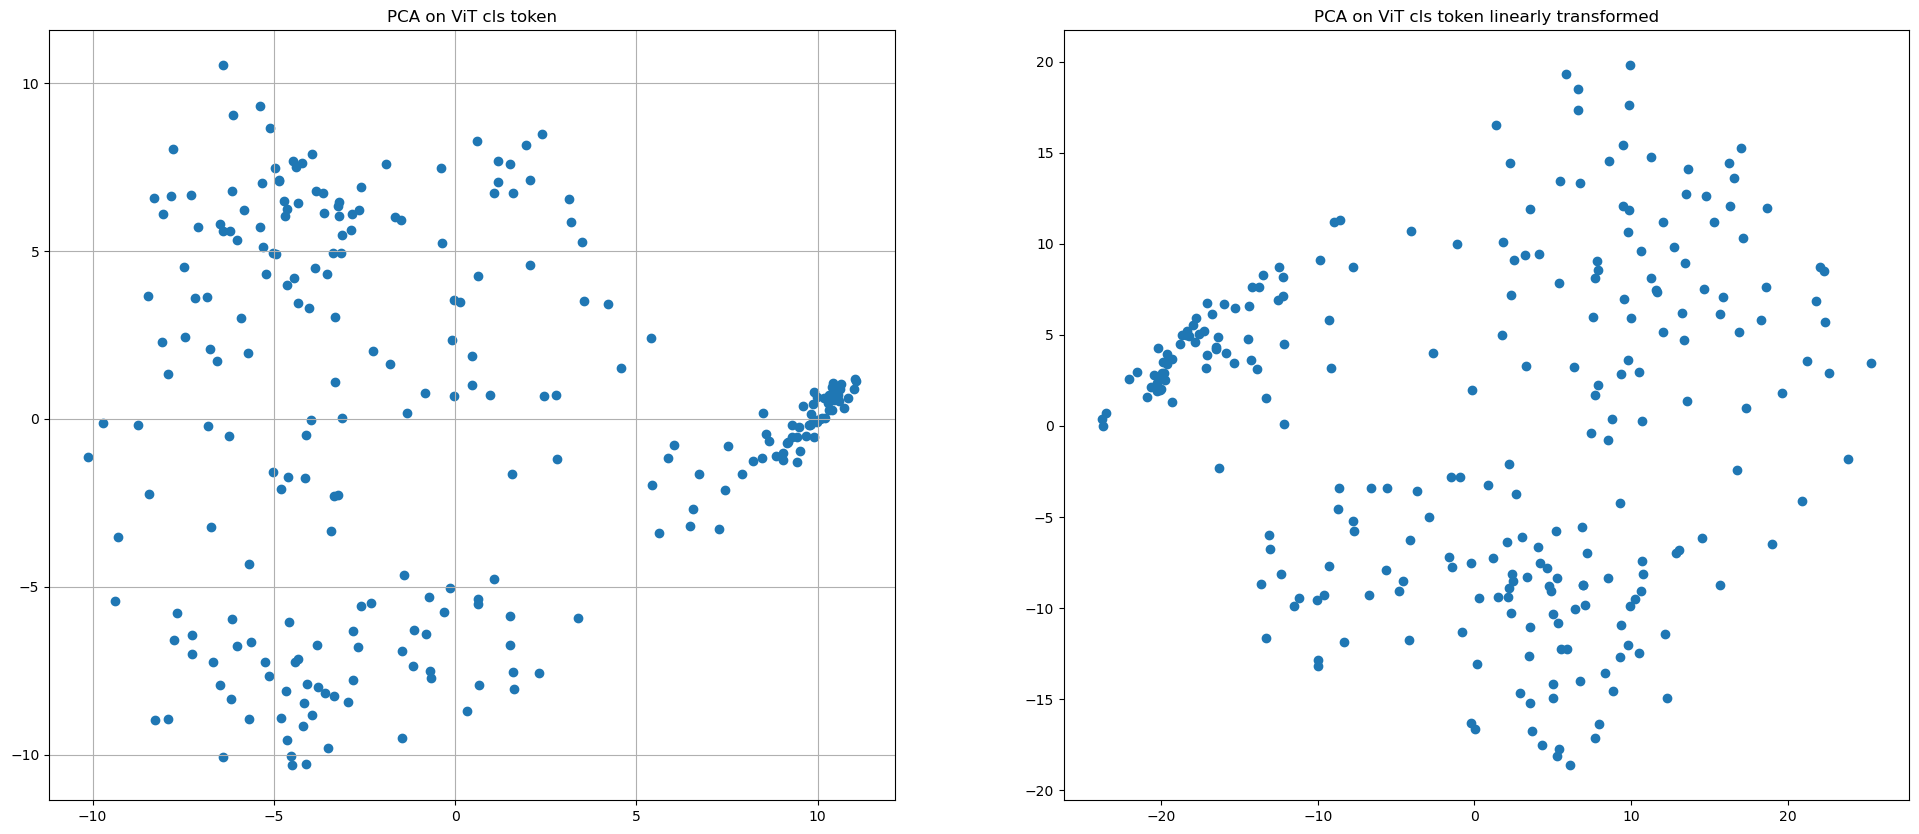

In [19]:
# get a 2d projection using PCA
# need to stack features into columns of a matrix. For the embedding that is 768d, we need a matrix like:
# 56 x 768, where 56 is the number of measurements (i.e, number of embeddings). Note that this is different from 
# the mathematical setup, where Y = PX is the output of the PCA transformation and each column of X has the 768d feature.
num_observations = len(img_dict)
X_cls_tokens = np.empty((num_observations,768))
for n, result in enumerate(qdrant_retrieval_cls_token):
    X_cls_tokens[n,:] = qdrant_retrieval_cls_token[n].vector

pca = PCA(n_components=2)
out_cls_tokens = pca.fit_transform(X_cls_tokens)

X_cls_transformed = np.empty((num_observations, 1000))
for n, result in enumerate(qdrant_retrieval_cls_linearly_transformed):
    X_cls_transformed[n,:] = qdrant_retrieval_cls_linearly_transformed[n].vector

pca = PCA(n_components=3)
out_cls_token_transformed = pca.fit_transform(X_cls_transformed)
print(out_cls_token_transformed.shape)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))
ax[0].scatter(out_cls_tokens[:,0], out_cls_tokens[:,1])
ax[0].set_title("PCA on ViT cls token")
ax[0].grid(visible = True)
ax[1].scatter(out_cls_token_transformed[:,0], out_cls_token_transformed[:,1])
ax[1].set_title("PCA on ViT cls token linearly transformed")




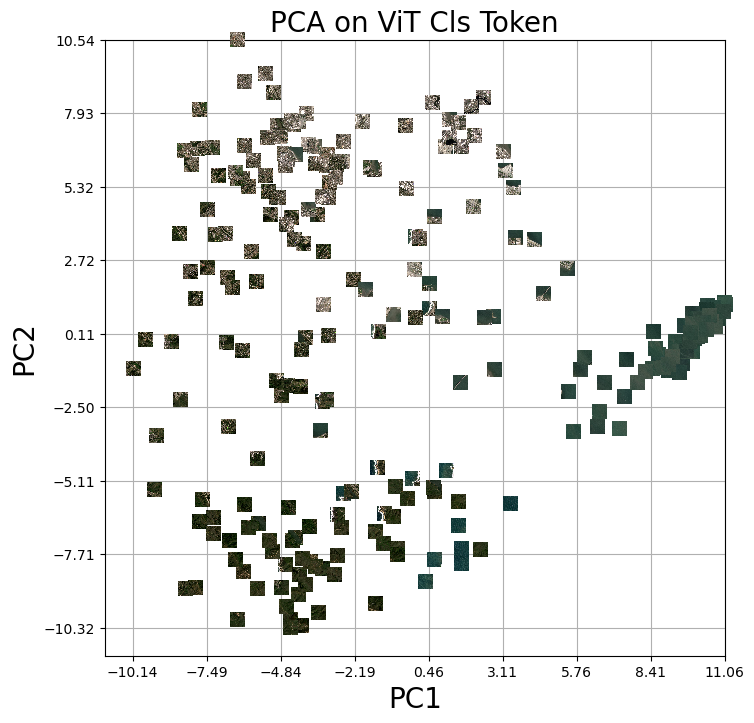

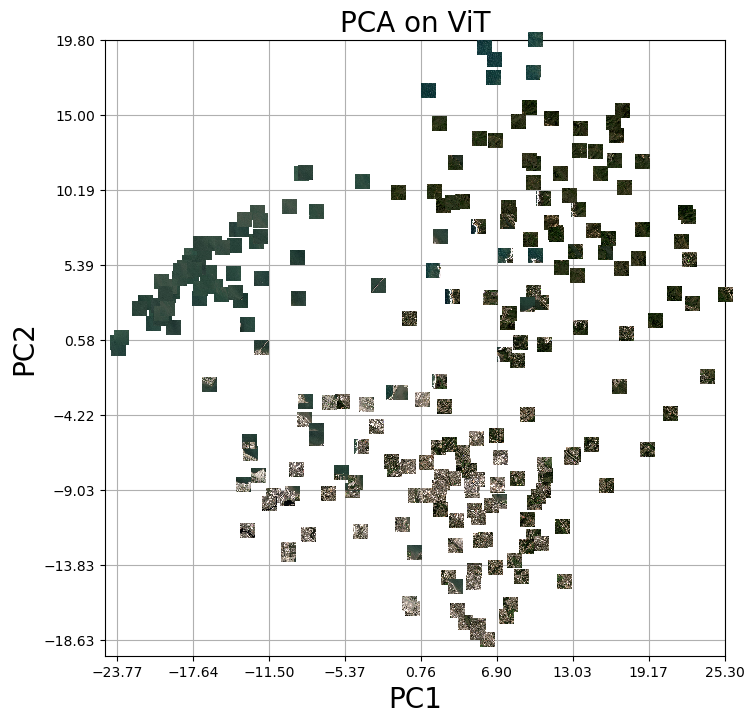

In [1027]:
# show image thumbnails on top of PCA to visualize how reduced dimensionality clustering looks like
render_2d_projection(out_cls_tokens, img_dict, num_states=64, title="PCA on ViT Cls Token")
render_2d_projection(out_cls_token_transformed, img_dict, num_states = 64)

Now we have extracted features and put them in a 2D space. We will now have to define our Markov Decision Process
A standard MDP in Reinforcement Learning will consist of states, actions, a transition function, a reward function, and a discount factor.
We will work in a discrete setting:
States will be made out of taking the min and max PC1 and min and max PC2 and chunking up 8 states along each axis.
Therefore, we will have 64 states.
Actions will be up, down, right, and left. 
Our gridworld will look like the gridworld below. 

[-10.14074039  -7.49015882  -4.83957726  -2.18899569   0.46158588
   3.11216745   5.76274902   8.41333058  11.06391215]
[-10.3205903   -7.71341676  -5.10624322  -2.49906968   0.10810386
   2.71527739   5.32245093   7.92962447  10.53679801]


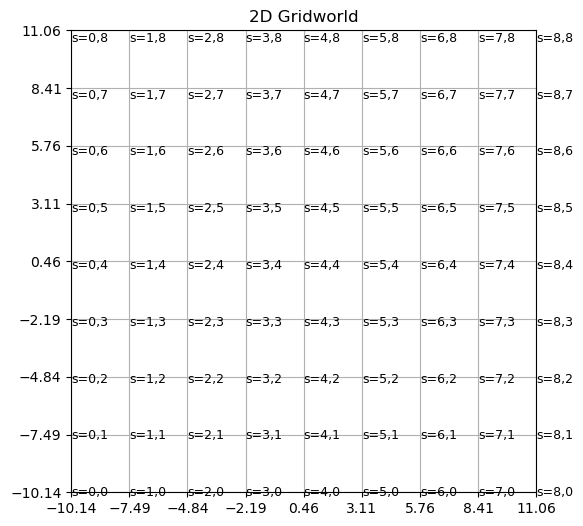

In [21]:
x_states, y_states, actions = mdp_setup(out_cls_tokens, num_states = 64)
print(x_states)
print(y_states)
grid = np.meshgrid(x_states, y_states)
fig, ax = plt.subplots(1,1, figsize=(6,6))
major_ticks = np.linspace(x_states[0], x_states[-1], 9) # so that we have 64 total states
minor_ticks = np.linspace(y_states[0], y_states[-1], 9) # so that we have 64 total states
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)
ax.grid(which='both')
ax.set_title("2D Gridworld")
for a, x in enumerate(x_states):
    for b, y in enumerate(y_states):
        ax.text(x, y, 's=' + str(a) + ',' + str(b), fontsize = 9)

In [22]:
import pandas as pd
print(out_cls_tokens.shape)
def setup_df(embedding_name, proj_model, img_dict, num_states): 
    ids = {'id' : img_dict.keys()}
    df = pd.DataFrame(ids)
    # add column for fps, x, y, z:
    df['fp'] = None
    df['x'] = None
    df['y'] = None
    df['z'] = None
    df['embedding_name'] = None
    df['proj_emb_coord'] = None
    df['state'] = None
    df['probe'] = False

    # create discrete state ranges based on num_states and min/max of PCA projections
    max_x = proj_model[:,0].max()
    min_x = proj_model[:,0].min()
    
    max_y = proj_model[:,1].max()
    min_y = proj_model[:,1].min()
    num_x_states = num_y_states = int(np.sqrt(num_states)) + 1
    
    x_range = np.linspace(min_x, max_x, num_x_states)
    y_range = np.linspace(min_y, max_y, num_y_states)
    print(x_range)
    print(y_range)
    
    for id in img_dict:
        df.loc[id, 'fp'] = img_dict[id][2]
        df.loc[id, 'x']  = img_dict[id][1][0]
        df.loc[id, 'y']  = img_dict[id][1][1]
        df.loc[id, 'z']  = img_dict[id][1][2]
        df.loc[id, 'embedding_name'] = embedding_name
        df.at[id, 'proj_emb_coord'] = proj_model[id]
        df.at[id, 'state'] = [int(np.searchsorted(x_range, proj_model[id,0], side='right')),
                              int(np.searchsorted(y_range, proj_model[id,1], side='right'))]
    
    return df
df = setup_df('cls_token', out_cls_tokens, img_dict, num_states = 64)
print(df.head)

(250, 2)
[-10.14074039  -7.49015882  -4.83957726  -2.18899569   0.46158588
   3.11216745   5.76274902   8.41333058  11.06391215]
[-10.3205903   -7.71341676  -5.10624322  -2.49906968   0.10810386
   2.71527739   5.32245093   7.92962447  10.53679801]
<bound method NDFrame.head of       id                                                 fp     x      y   z  \
0      0  /Users/alim/Documents/ECE595RL/local_tiles/523...  5232  12681  15   
1      1  /Users/alim/Documents/ECE595RL/local_tiles/523...  5232  12682  15   
2      2  /Users/alim/Documents/ECE595RL/local_tiles/523...  5232  12683  15   
3      3  /Users/alim/Documents/ECE595RL/local_tiles/523...  5232  12684  15   
4      4  /Users/alim/Documents/ECE595RL/local_tiles/523...  5232  12685  15   
..   ...                                                ...   ...    ...  ..   
245  245  /Users/alim/Documents/ECE595RL/local_tiles/525...  5256  12686  15   
246  246  /Users/alim/Documents/ECE595RL/local_tiles/525...  5256  12687  15   
2

Now that we have discretized states, we can randomly initialize a policy and generate trajectories

In [1053]:
actions = np.array(['u', 'd', 'r', 'l'])

Let's generate a random policy so we can generate a trajectory. 

Some helper functions are below.

In [616]:
def create_random_policy(grid_size, num_actions):
    """
    Create a random policy for a 2D gridworld.

    Parameters:
    - grid_size: Tuple representing the size of the grid (rows, columns).
    - num_actions: Number of possible actions for each state.

    Returns:
    - policy: 2D array representing the random policy.
    
    mapping = {0 : 'up',
           1 : 'down',
           2: 'right',
           3: 'left'}
    """ 

    policy = np.random.randint(0, num_actions, size=(grid_size, grid_size))
    
    # make sure policy does not have any "out of bounds" actions
    for r in range(policy.shape[0]):
        for c in range(policy.shape[1]):

            if r == 0: # make sure we do not go up from first row
                if policy[r,c] == 0:
                    policy[r,c] = np.random.randint(1,3, 1)
            if r == 7: # make sure we do not go down from last row
                if policy[r,c] == 1:
                    valid_actions = list(set(actions).difference(set([1])))
                    valid_actions = np.array(valid_actions)
                    policy[r,c] = np.random.choice(valid_actions, p=[1/3, 1/3, 1/3])
            if c == 0: # make sure we do not go left from first col
                if policy[r, c] == 3:
                    valid_actions = list(set(actions).difference(set([3])))
                    valid_actions = np.array(valid_actions)
                    policy[r,c] = np.random.choice(valid_actions, p=[1/3, 1/3, 1/3])
            if c == 7: # make sure we do not go right from last col
                if policy[r,c] == 2:
                    valid_actions = list(set(actions).difference(set([2])))
                    valid_actions = np.array(valid_actions)
                    policy[r,c] = np.random.choice(valid_actions, p=[1/3, 1/3, 1/3])
            # take care of corners:
            
            if r == 0 and c == 0: 
                if policy[r,c] == 0 or policy[r,c] == 3:
                    policy[r,c] = np.random.choice([1,2], p= [0.5, 0.5])
            if r == 0 and c == 7:
                if policy[r,c] == 0 or policy[r,c] == 2:
                    policy[r,c] = np.random.choice([1,3], p = [0.5, 0.5])
            if r == 7 and c == 0:
                if policy[r,c] == 1 or policy[r,c] == 3:
                    policy[r,c] = np.random.choice([0, 2], p = [0.5, 0.5])
            if r == 7 and r == 7:
                if policy[r,c] == 1 or policy[r,c] == 2:
                    policy[r,c] = np.random.choice([0, 3], p = [0.5, 0.5])
                    
    return policy

def choose_init_state(grid_size=8, user_subset=True, fully_random=False, state=[3,3]):
    """
    We can either choose states completely randomly or give a probe index as a starting point
    user_subset means we will get the images from the probe_idx
    fully_random means we will select an initial state completely randomly from gridworld
    """
    if fully_random:
        init_state_x = np.random.randint(1, grid_size + 1, 1)
        init_state_y = np.random.randint(1, grid_size + 1, 1)
        init_state = [int(init_state_x), int(init_state_y)]
    if user_subset:
        init_state = [3,3]
        
    return init_state

def choose_action(state, policy):
    """
    state is a 2 element list. Find the corresponding action for that state in the policy
    """
    
    # Define stochastic policy probabilities
    policy_based_action = policy[state[0], state[1]]
    
    # introduce stochasticity into choosing action. Follow policy with p = .5, p = 0.5/3 over other three choices
    if policy_based_action == 0: 
        action_probabilities = [0.5, 0.5/3, 0.5/3, 0.5/3]
    if policy_based_action == 1:
        action_probabilities = [0.5/3, 0.5, 0.5/3, 0.5/3]
    if policy_based_action == 2:
        action_probabilities = [0.5/3, 0.5/3, 0.5, 0.5/3] 
    if policy_based_action == 3:
        action_probabilities = [0.5/3, 0.5/3, 0.5/3, 0.5] 

    # Sample action based on the probabilities
    action = np.random.choice([0, 1, 2, 3] ,1, p=action_probabilities)
    
    # validation of whether action is valid will happen in get_next_state()
    
    return action

def choose_image_from_ambiguous(filtered_df):
    """
    If we have a state that has multiple image, choose one
    """
    temp_len = filtered_df.shape[0]
    uniform_probability = 1 / temp_len
    p = np.repeat(uniform_probability, temp_len).tolist()    
    choice = np.random.choice(filtered_df['id'].values.tolist(), 1, p) # randomly pick an image that belongs to the state.
    return choice

def get_image_for_state(df, state):

    filtered_df_test = df[df['state'].map(lambda x: x == state)] # use this to filter for a LIST inside a Pdframe
    #print(filtered_df_test)
    #print('num images from init state', filtered_df_test.shape[0])

    if filtered_df_test.shape[0] > 1:
        choice = choose_image_from_ambiguous(filtered_df_test)
    else:
        choice = filtered_df_test['id'].values
    
    if choice.shape[0] == 0:
        #print('no image in state!!!')
        temp_img = None
        
    #print('this is choice!!', choice)
    if choice.shape[0] != 0: # only get image fp if an image is in that state.
        temp_fp = filtered_df_test.loc[choice, 'fp'].values[0]
        temp_img = Image.open(temp_fp)
    
    return choice, filtered_df_test, temp_img
    
    
def get_next_state(action, prev_state):
    """
    Given action that we generate from the function choose_action(), get the next state
    We will need to validate that next state is in fact within the discrete state boundaries
    """
    if action == 0: # up
        next_state = [max(1, prev_state[0] - 1), prev_state[1]] # if we go up, we will need to subtract 1 from
        # the first component of the state space but also make sure we do not go below 0. Therefore, we take
        # the max(0, prev_state[0])
    if action == 1: # down
        next_state = [min(prev_state[0] + 1, 7), prev_state[1]]
    if action == 2: # right
        next_state = [prev_state[0], min(prev_state[1] + 1, 7)]
    if action == 3: # left
        next_state = [prev_state[0], max(1, prev_state[1] - 1)]
    #print('action was', action , 'and next state was', next_state, '!!!!!')

    return next_state


def generate_trajectory(traj_len, policy):
    for i in range(traj_len):

        if i == 0:
            trajectory = [] # init a list to hold trajectory
            # start at random state:
            prev_state = choose_init_state()
            #print('trajectory starts with:', prev_state)
            trajectory.append(prev_state)
            
        # get image from state
        choice, filtered_df_test, temp_img = get_image_for_state(df, prev_state)
        trajectory.append(temp_img)

        #now, we that we have a state, choose an action. Our policy should tell us the mapping.
        # but we also want to have a stochasticity in our 
        temp_action = choose_action(prev_state,policy)
        trajectory.append(temp_action)
        #print('trajectory so far:', trajectory)

        # get new state based on the previous (s,a) pair.
        #print('current state:', prev_state)
        #print('current action!!!', temp_action)

        next_state = get_next_state(temp_action, prev_state)
        trajectory.append(next_state) # add next_state to trajectory
        prev_state = next_state
    
    return trajectory


def display_trajectory(trajectory, title : str):
    fig, ax = plt.subplots(1, 5, figsize=(10,10))
    state = 0
    for n, i in enumerate(trajectory):
        if n % 3 == 0:
            state = i
        if n % 3 == 1: 
            if i != None:
                temp_img = np.uint8(i)
                ax[n // 3].imshow(temp_img)
                ax[n // 3].set_title(title + ':' + str(state[0]) + ',' + str(state[1]))
            if i == None:
                temp_img = np.ones((255, 255, 3), dtype=np.uint8) * 255
                ax[n // 3].imshow(temp_img)
                ax[n // 3].set_title(title + ':' + str(state[0]) + ',' + str(state[1]))
    

def setup_hf_db():
    
    df_hf = pd.DataFrame()
    df_hf['id'] = None
    df_hf['preferred_traj'] = None
    df_hf['trajectory_1'] = None
    df_hf['trajectory_2'] = None
    
    return df_hf


We also should hold some images in our df to be "probes". That will allow our trajectories to give apples to apples comparisions. 

[175.] !!!! <class 'numpy.ndarray'>


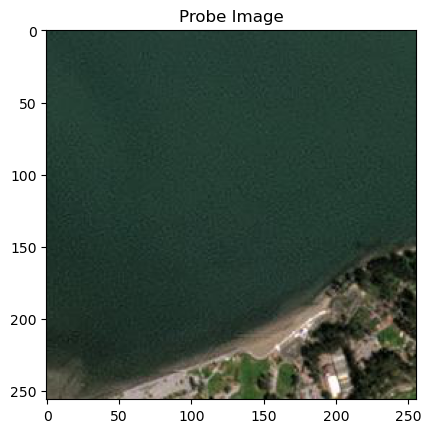

In [36]:
### Select the one image from state [3,3] to be probe. It has a coast line and water. I want to find more 
# water like features or more land like features with my human feedback on the policy. 

disp_df1 = df[df['state'].map(lambda x: x == [3,3])]
probe_idx = disp_df1['id'].values
print(probe_idx, '!!!!', type(probe_idx))
df.loc[int(probe_idx), 'probe'] = True
fig, ax = plt.subplots(1, disp_df1.shape[0])
for n, i in enumerate(disp_df1['id'].values):
    temp_fp = disp_df1.loc[i,'fp']
    temp_img = Image.open(temp_fp)
    temp_img_np = np.uint8(temp_img)
    ax.imshow(temp_img_np)
    ax.set_title('Probe Image')
    
# We have set the image displayed below as the probe. 

Let's generate two different trajectories based on the same random policy so we can have a human compare them. 
However, we should have the same initial state so that we can compare both trajectories to show which one 
a human prefers.

In [610]:
mapping = {0 : 'up',
           1 : 'down',
           2: 'right',
           3: 'left'}
set_actions = {0, 1, 2, 3}
actions = [0,1,2,3]
policy1 = create_random_policy(8, 4)

trajectory1 = generate_trajectory(5, policy1)
trajectory2 = generate_trajectory(5, policy2)


# Now that we have a mechanism to build trajectories, let's build a system to rate them and save rating to a database. 

Specifically, db should have traj 1, traj 2, and a weighted mass between 1 and 2. All mass in 1 indicates preference for traj 1 > traj 2, and all mass in 2 indicates preference for traj 2 > traj 1. Equally distributed mass indicates traj 1 == traj 2 in terms of human preference.

Rating criteria:
If we get more coastal images, or partial water images, we prefer that trajectory

If we get all water, do not prefer

If we get land locked images, do not prefer.

In [243]:
# just instantiate a df to hold preferences
df_hf = setup_hf_db()

IntText(value=0, description='Traj 1 or Traj 2?:')

Button(description='Submit Preference', style=ButtonStyle())

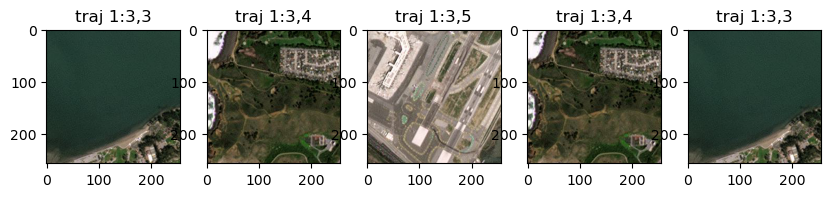

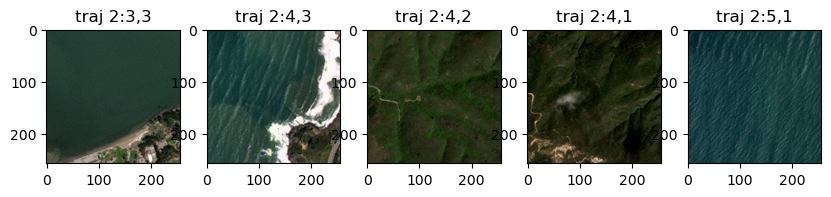

In [1054]:
number_input = widgets.IntText(description='Traj 1 or Traj 2?:')


trajectory1 = generate_trajectory(5, policy1) 
trajectory2 = generate_trajectory(5, policy2)

display_trajectory(trajectory1, "traj 1")
display_trajectory(trajectory2, "traj 2")


def update_dataframe(preferred_traj):
    """
    1 means prefer traj 1
    2 means prefer traj 2
    3 means equal preference
    """
    global df_hf
    
    # just get states and actions from trajectory
    trajectory1_dfhf = []
    trajectory2_dfhf = []
    for n, i in enumerate(trajectory1):
        if n % 3 == 0:
            trajectory1_dfhf.append(i)
        if n % 3 == 2:
            trajectory1_dfhf.append(i)
    
    for n, i in enumerate(trajectory2):
        if n % 3 == 0:
            trajectory2_dfhf.append(i)
        if n % 3 == 2:
            trajectory2_dfhf.append(i)
            

    num_rows = df_hf.shape[0]
    next_training_point = {'id' : num_rows + 1, 'preferred_traj' : preferred_traj, 'trajectory_1' : trajectory1_dfhf,
               'trajectory_2' : trajectory2_dfhf}
    new_row = pd.Series(next_training_point)
    df_hf = pd.concat([df_hf, new_row.to_frame().T], ignore_index=True)

# Create button widget
update_button = widgets.Button(description='Submit Preference')
update_button.on_click(lambda buttonfunc: update_dataframe(number_input.value))

# Display widgets
display(number_input)
display(update_button)



In [951]:
df_hf


,index,id,preferred_traj,trajectory_1,trajectory_2
0,0,0,3,"[[3, 3], [0], [2, 3], [1], [3, 3], [2], [3, 4]...","[[3, 3], [2], [3, 4], [1], [4, 4], [1], [5, 4]..."
1,1,1,2,"[[3, 3], [0], [2, 3], [1], [3, 3], [2], [3, 4]...","[[3, 3], [1], [4, 3], [0], [3, 3], [1], [4, 3]..."
2,2,2,1,"[[3, 3], [1], [4, 3], [0], [3, 3], [1], [4, 3]...","[[3, 3], [2], [3, 4], [1], [4, 4], [1], [5, 4]..."
3,3,3,2,"[[3, 3], [1], [4, 3], [3], [4, 2], [0], [3, 2]...","[[3, 3], [1], [4, 3], [0], [3, 3], [2], [3, 4]..."
4,4,4,3,"[[3, 3], [0], [2, 3], [1], [3, 3], [1], [4, 3]...","[[3, 3], [1], [4, 3], [0], [3, 3], [3], [3, 2]..."
5,5,5,3,"[[3, 3], [2], [3, 4], [3], [3, 3], [3], [3, 2]...","[[3, 3], [1], [4, 3], [0], [3, 3], [2], [3, 4]..."
6,6,6,2,"[[3, 3], [1], [4, 3], [1], [5, 3], [3], [5, 2]...","[[3, 3], [1], [4, 3], [3], [4, 2], [1], [5, 2]..."
7,7,7,2,"[[3, 3], [1], [4, 3], [0], [3, 3], [3], [3, 2]...","[[3, 3], [1], [4, 3], [0], [3, 3], [0], [2, 3]..."
8,8,8,2,"[[3, 3], [3], [3, 2], [1], [4, 2], [3], [4, 1]...","[[3, 3], [1], [4, 3], [0], [3, 3], [1], [4, 3]..."
9,9,9,3,"[[3, 3], [1], [4, 3], [3], [4, 2], [2], [4, 3]...","[[3, 3], [0], [2, 3], [1], [3, 3], [1], [4, 3]..."


in compute_segment_preferences and r_hat_traj1 is using updated weights? False
initial y_hats from random init weights: [0.51840818 0.3710098  0.60275395 0.57756405 0.54784125 0.51286444
 0.48935237 0.48643853 0.39501386 0.49431187 0.38176047 0.45804437
 0.47606539 0.40982668 0.5417909  0.39272505 0.62244984 0.46093728
 0.47246818 0.51778651 0.51403878 0.52941526 0.58597522 0.46647042
 0.41517488 0.51677973 0.48695788 0.37730921]
total loss over entire dataset is 14.500151709194744
the initial weights: [ 0.14901425 -0.04147929  0.19430656  0.45690896 -0.07024601]
running optimize
in compute_segment_preferences and r_hat_traj1 is using updated weights? True
total loss over entire dataset is 14.463745899236168
-14.463745899236168
running optimize
in compute_segment_preferences and r_hat_traj1 is using updated weights? True
total loss over entire dataset is 14.42889636819371
-14.42889636819371
running optimize
in compute_segment_preferences and r_hat_traj1 is using updated weights? True
t

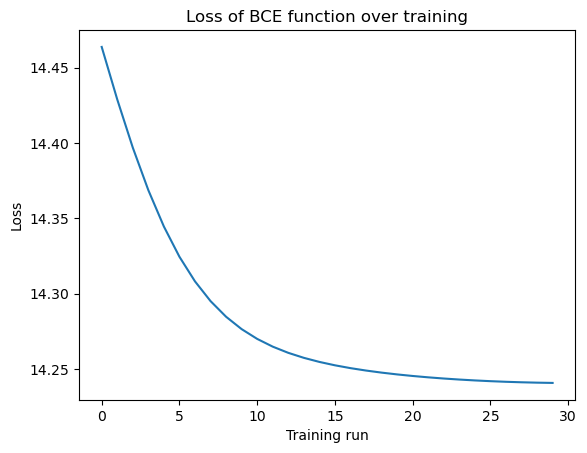

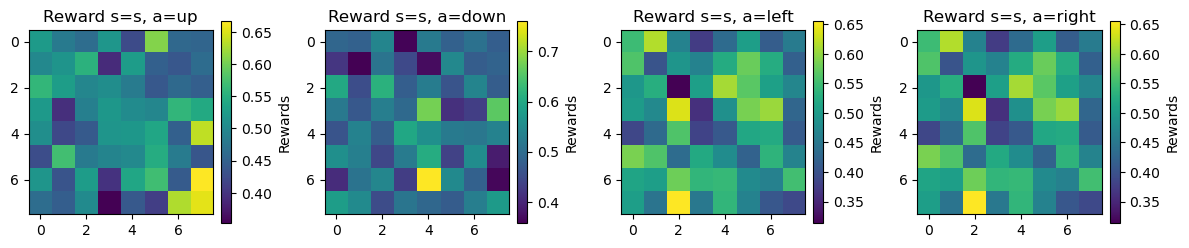

Statistics:
Mean of Rewards Before Human Feedback 0.5005
Variance of Rewards Human Feedback 0.0052
Min and max of rewards before Human Feedback 0.2744 0.7158
Mean of Rewards After Human Feedback: 0.5363
Variance of Rewards After Human Feedback: 0.0175
Min and max of rewards After Human Feedback 0.313 1.0


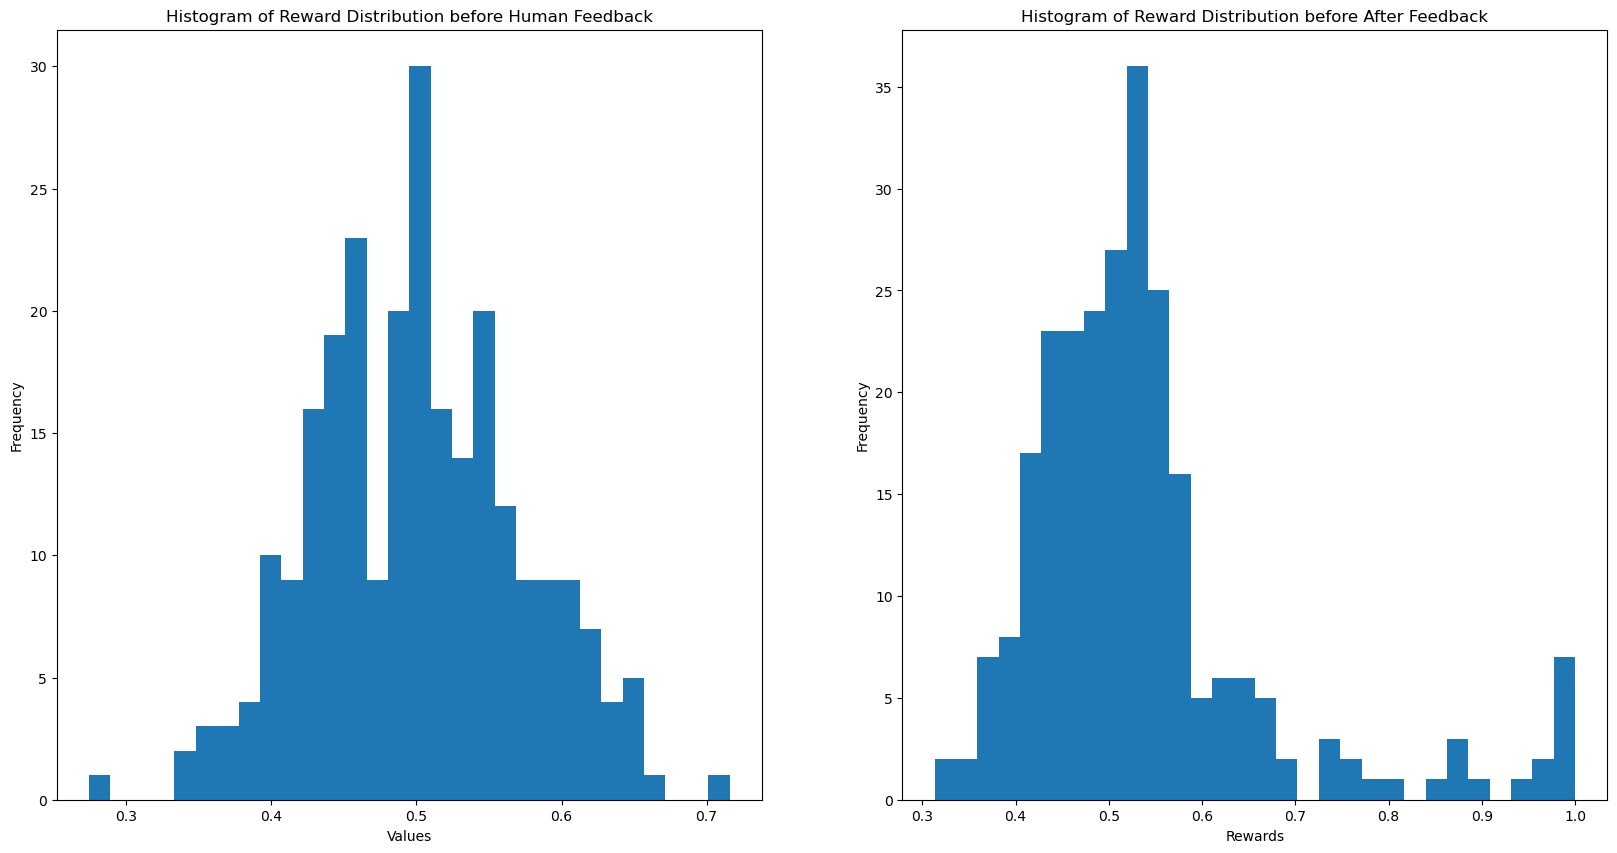

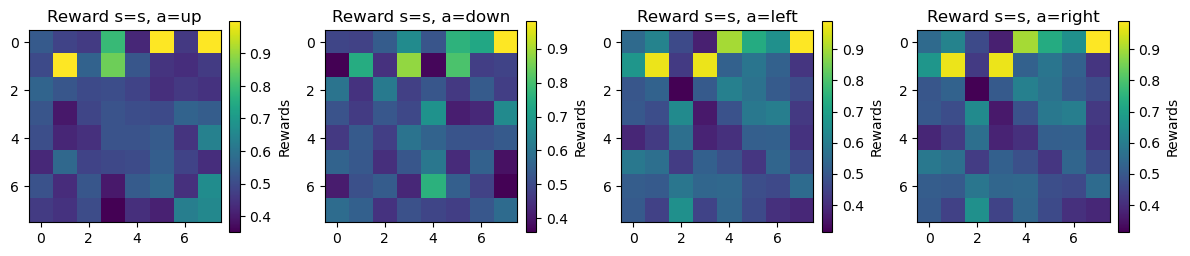

In [1019]:
# We need an estimator for the reward function. Then, we can plug that estimator into the the equation to 
# estimate the probability that traj 1 is preferred over traj 2 (equation 1 in Deep RL w/ Human Preferences
# paper).
# Then, using that estimate and the weighted mass from the database, we can compute a loss, which we use
# to optimze the reward function. The loss is cross entropy loss, since we are dealing with a categorical 
# variable.
# Later on, we can expand the classes of functions for the reward estimator to be other statiscal models
# or even a deep neural network. 

# Let's use logistic regression as a first pass at the reward estimator. Reward will be 1 or 0. 
# Input to logistic regression will be state and action pairs. We want to treat these inputs as categorical,
# because states and actions are discrete in this setting. 

# Let each (s,a) pair be a one hot encoding. We have 64 states and 4 actions. So, we have 64 * 4 = 256 one hot 
# vectors. 

# create 256 one hot encoded vectors:
s_a_features = np.eye(256) # a row or col can be used for a one hot feature.
# Specifically, we start our indexing at the BOTTOM LEFT, therefore, let's make sure we know which one hot 
# vector corresponds to which (state, action) pair. 
# Row 1 : state (1,1), action up
# Row 2 : state (1,1), action down
# Row 3 : state (1,1), action right
# Row 4 : state (1,1), action left
# Row 5 : state (1,2), action up.
# ...
# ...
# Row 255: state (8,8), action right
# Row 256: state (8,8), action left

def reward(state_action_pair, s_a_features=s_a_features, updated_weights=None, use_updated_weights=False):
    """
    state action pair is an integer in range [1, 256], as there are 64 states, 4 actiosn.
    i.e, |S| = 64, |A| = 4
    This state action pair will pick off a specific one hot encoding in s_a_features (an identity matrix)
    
    We are using a logistic regression function to be a reward estimator. This can be swapped out in the 
    future for a different estimator, like a neural network. But we will start with a simple estimator.
    
    Logistic regresssion has the form:
    exp(B1X1 + B2X2 + ... + BNXN) / 1 + exp(B1X1 + B2X2 + ... + BNXN), where X are one hot vectors for a 
    state/action pair and B is a vector of randomly initialized weights.
    
    Output values will always be between 0 and 1 (property of logistic regression)
    """
    
    feature = s_a_features[state_action_pair] # pick off one hot vector corresponding to a state action pair
    weights = np.random.normal(loc = 0, scale = 0.3, size=256) # randomly initialize weights
    
    if use_updated_weights:
        estimated_reward = 1 / (1 + np.exp(-(feature @ updated_weights))) # dot product of a one hot vector and the weights
        return estimated_reward, updated_weights
    else:
        np.random.seed(42) # set seed for reproducibility. We have to randomly initialize weights
        estimated_reward = 1 / (1 + np.exp(-(feature @ weights))) # dot product of a one hot vector and the weights
        return estimated_reward, weights

def sum_rewards_in_trajectory(trajectories, updated_weights=None, use_updated_weights=False):
    """
    Input list of trajectories, compute the estimated rewards based on reward estimator.

    Returns a list with the of rewards for each trajectory in the list of trajectories

    """
    rewards_over_trajectories = [] # stores the sum of rewards for each trajectory.
    # for example, if the input variables trajectories has 10 trajectories, this 
    # rewards_over_trajectories list should have 10 values
    for x, traj in enumerate(trajectories):
        #print('on trajectory', x)
        #print('trajectory is', traj)
        a = -99 # dummy var for action
        s = -99 # dummy var for state
        reward_list_traj = [] # empty list to store rewards from one trajectory. If trajectory (denoted
        # by the variable traj) has 10 elements (5 s,a pairs), program should have 5 elements in this 
        # list by the time we fully populate this list.
        for n, s_a in enumerate(traj):
            if n % 2 == 0:
                s = s_a # save state from pandas db. 
                s = [s[0] -1, s[1] - 1] # update indexing for np.ravel_multi_index func

                #print('state in 2d for unraveled index is', s)

                state_unraveled = np.ravel_multi_index((s), (8,8)) * 4 # convert 2d gridworld coordinate to 1d
                #print('this corresponds to state in 1d:', state_unraveled)
            if n % 2 == 1:
                a = s_a # should only be integers in range [0,3]
                #print('action is', a)
                state_action_unraveled = state_unraveled + a
                #print('run reward function on:', state_action_unraveled)

                # we have s_a pair, run reward function:
                reward_output = reward(state_action_unraveled, s_a_features=s_a_features, 
                                       updated_weights=updated_weights, 
                                       use_updated_weights=use_updated_weights)[0]
                reward_list_traj.append(reward_output) # add reward for specific state/action pair
                # to 

                #print('reward output', reward_output)
            if n == len(traj) - 1: # hitting this condition means we are in the last action of 
                # trajectory. We should sum up all the rewards. 
                summed_rewards_over_one_traj = np.sum(np.array(reward_list_traj))
                #print(summed_rewards_over_one_traj)
                # add this sum of rewards to list of summed rewards:
                rewards_over_trajectories.append(summed_rewards_over_one_traj)

    
    return rewards_over_trajectories
    
def compute_segment_preferences(trajectories1, trajectories2, updated_weights=None, use_updated_weights=False):
    """
    Apply equation 1 from Deep Reinforcement Learning from Human Prefernces paper. It looks like an instance
    of the Bradley–Terry model.
    
    The equation is a softmax and used to interpret probability of preferring segment 1 over segment 2.
    
    This probability will eventually be used in computing a cross entropy loss which will indicate how well
    we have found the best model parameters
    
    Overall, this function returns our estimate y_hat. The estimate of human reward.
    """
    
    r_hat_traj1 = sum_rewards_in_trajectory(trajectories1, updated_weights=updated_weights,
                                           use_updated_weights=use_updated_weights)
    print('in compute_segment_preferences and r_hat_traj1 is using updated weights?', use_updated_weights)
    r_hat_traj2 = sum_rewards_in_trajectory(trajectories2, updated_weights=updated_weights,
                                           use_updated_weights=use_updated_weights)
    
    # this next line computes the estimated reward, y_hat, aka P_hat[traj1 > traj2]
    y_hats_per_traj = np.exp(r_hat_traj1) / (np.exp(r_hat_traj1) + np.exp(r_hat_traj2))
    
    return r_hat_traj1, r_hat_traj2, y_hats_per_traj

def compute_loss(y_hats_per_traj):
    """
    This function computes cross entropy loss between predictions and human labeled preference.
    
    Labeled preference is computed from the function compute_segment_preferences. compute_segment_preferences
    is assuming the "human's probability of preferring a segment depends exponentially on the value of
    rewards summed over the length of the clip" ("trajectory" is the clip in this code). The original paper
    was feeding video clips to humans
    """
    total_loss = 0
    individual_losses = []
    for n, row in enumerate(range(df_hf.shape[0])):
        # compute the weighting over the distribution {1,2} per the paper
        mass = df_hf.loc[row, 'preferred_traj'] 
        if mass == 1: # all weight should be on mu_1
            mu_1 = 1
            mu_2 = 0
        if mass == 2: # all weight should be on mu_2
            mu_1 = 0
            mu_2 = 1
        else:
            mu_1 = mu_2 = 0.5 # equally distributed mass
            
        individual_losses.append(mu_1 * y_hats_per_traj[n] + mu_2 * (1 - y_hats_per_traj[n]))    
        total_loss+= mu_1 * y_hats_per_traj[n] + mu_2 * (1 - y_hats_per_traj[n])
        
    print('total loss over entire dataset is', total_loss)
    return -total_loss, individual_losses

def optimize_reward_function(theta, r_hat_traj1, r_hat_traj2, df_hf=df_hf, lr = 0.1):
    """
    This function implements gradient descent to find an optimal reward function
    
    Note that logistic regression is convex, so we should not get stuck in local minimums.
        
    theta is the existing weights.
    
    P_s1_over_s2 is our estimated prefernce-predictor, or in other words, the y_hat in CE loss.
    """
    # Note that for BCE loss, gradient of loss w.r.t parameter xi simplifies to d = (y_hat - y) * xi
    # theta_update = theta - lr * d is gradient descent
    # We are creating a feature vector X to have a 1 when a s,a pair is visited. 

    theta_update = 0 # just to initialize variable. 
    for n in range(df_hf.shape[0]):
        # compute y, the human preferred label. Will be needed in the computation of the gradient of the 
        # cross entropy loss. This is represented in the PMF over {1,2} per the paper notation.
        mass = df_hf.loc[n, 'preferred_traj']
        state_actions_represented1 = df_hf.loc[n, 'trajectory_1']
        state_actions_represented2 = df_hf.loc[n, 'trajectory_2']
        li_one_d_state_action_features_traj1 = []
        li_one_d_state_action_features_traj2 = []
        for n, (states_actions1, states_actions2) in enumerate(zip(state_actions_represented1, state_actions_represented2)):
            # generate list of s,a pairs that were essentially the input features to generate our y_pred
            if n % 2 == 1: # we have a (s,a) pair
                temp_state1 = state_actions_represented1[n - 1] 
                temp_action1 = state_actions_represented1[n]
                temp_state2 = state_actions_represented2[n - 1]
                temp_action2 = state_actions_represented2[n]
                # get 1d corresponding s,a pair (a number between 1 and 256). This will tell us what
                # our input feature is for logistic regression and our optimization. 
                
                one_d_state_actions_1 = np.ravel_multi_index(temp_state1, (8,8)) + temp_action1
                one_d_state_actions_2 = np.ravel_multi_index(temp_state2, (8,8)) + temp_action2
                # the next two lines have the features (i.e, X vector) that were used in computing y_pred
                # for example, our trajectory went over states [1,2], action up [2,2], action up, [3,2] 
                # action up, then those moves correspond to certain parts of our feature vector.
                li_one_d_state_action_features_traj1.append(one_d_state_actions_1)
                li_one_d_state_action_features_traj2.append(one_d_state_actions_2)
                
        
        #print('list of s,a pairs:', li_one_d_state_action_features_traj1)
        #print('list of s,a pairs:', li_one_d_state_action_features_traj2)
        
        X = np.zeros(256)
        for n ,(features1, features2) in enumerate(zip(li_one_d_state_action_features_traj1, 
                                                       li_one_d_state_action_features_traj2)):
            X[features1] = 1
            X[features2] = 1
                
        #print(X)
                
        if mass == 1: # GT is traj 1
            y = 0
        if mass == 2: # GT is traj 2
            y = 1
        else:
            y = 0.5 # equal preference
        
        # now fetch y_pred, which is computed using equation 1 in paper.
        y_pred = np.exp(r_hat_traj1[n]) / (np.exp(r_hat_traj2[n]) + np.exp(r_hat_traj2[n]))
        
        # perform gradient ascent update
        theta_update = theta - (lr * (y_pred - y) * X)
        
        theta = theta_update
    #print('theta update is', theta_update[0:5])
    return theta_update

def display_reward_grid(updated_weights=None, use_updated_weights=False, heatmaps = False, title="title",
                       textmap=False, statistics=False):
    #print('reward function with random weights:')
    reward_grid = np.empty((8,8,4))
    reward_grid_before_feedback = np.empty((8,8,4))
    for state_action_pair in range(256):
        # Use unravel_index to convert the 1D index to multi-dimensional indices specified in reward_grid.shape
        unraveled_indices = np.unravel_index(state_action_pair, reward_grid.shape)
        temp_reward = reward(state_action_pair, s_a_features=s_a_features, 
                             updated_weights=updated_weights, use_updated_weights=use_updated_weights)[0]
        temp_reward_without_feedback = reward(state_action_pair, s_a_features=s_a_features, use_updated_weights=False)[0]
        reward_grid_before_feedback[unraveled_indices] = temp_reward_without_feedback
        reward_grid[unraveled_indices] = temp_reward
    
    if statistics:
        print("Statistics:")
        print("Mean of Rewards Before Human Feedback", np.round(np.mean(reward_grid_before_feedback), 4))
        print("Variance of Rewards Human Feedback", np.round(np.var(reward_grid_before_feedback), 4))
        print("Min and max of rewards before Human Feedback", np.round(np.min(reward_grid_before_feedback), 4), 
                                                            np.round(np.max(reward_grid_before_feedback), 4))
        
    
        # Create a histogram
        fig, ax = plt.subplots(1,2, figsize = (20,10))
        ax[0].hist(reward_grid_before_feedback.flatten(), bins=30)
        ax[0].set_xlabel('Values')
        ax[0].set_ylabel('Frequency')
        ax[0].set_title('Histogram of Reward Distribution before Human Feedback')
        
        ax[1].hist(reward_grid.flatten(), bins=30)
        ax[1].set_xlabel('Rewards')
        ax[1].set_ylabel('Frequency')
        ax[1].set_title('Histogram of Reward Distribution before After Feedback')

        print("Mean of Rewards After Human Feedback:", np.round(np.mean(reward_grid), 4))
        print("Variance of Rewards After Human Feedback:", np.round(np.var(reward_grid), 4))
        print("Min and max of rewards After Human Feedback", np.round(np.min(reward_grid),4), 
                                                              np.round(np.max(reward_grid), 4))
    if textmap:
        for a in range(4):
            print("Rewards for action", a, "\n")
            print(reward_grid[:,:,a])
    
    if heatmaps:
        fig, ax = plt.subplots(1,4, figsize=(12,8))

        rewardmap0 = ax[0].imshow(reward_grid[:,:,0], cmap='viridis')
        rewardmap1 = ax[1].imshow(reward_grid[:,:,1], cmap='viridis')
        rewardmap2 = ax[2].imshow(reward_grid[:,:,2], cmap='viridis')
        rewardmap3 = ax[3].imshow(reward_grid[:,:,2], cmap='viridis')
        
        # add color bar
        colorbar1 = fig.colorbar(rewardmap0, ax=ax[0], label='Rewards', fraction=0.05, pad=0.04)
        colorbar2 = fig.colorbar(rewardmap1, ax=ax[1], label='Rewards', fraction=0.05, pad=0.04)
        colorbar3 = fig.colorbar(rewardmap2, ax=ax[2], label='Rewards', fraction=0.05, pad=0.04)
        colorbar4 = fig.colorbar(rewardmap3, ax=ax[3], label='Rewards', fraction=0.05, pad=0.04)
        
        ax[0].set_title('Reward s=s, a=up')
        ax[1].set_title('Reward s=s, a=down')
        ax[2].set_title('Reward s=s, a=left')
        ax[3].set_title('Reward s=s, a=right') 
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

# generate a list of estimates for model in y_hats_per_traj. Use default initial model weights.   
r_hat_traj1, r_hat_traj2, y_hats_per_traj = compute_segment_preferences(df_hf['trajectory_1'], 
                                                                        df_hf['trajectory_2']) 

# compute loss
print('initial y_hats from random init weights:', y_hats_per_traj)
loss, ind_losses = compute_loss(y_hats_per_traj)
# get initial model weights, theta
_, theta = reward(0) # get initial weights to drop into optimization function.
print('the initial weights:', theta[0:5])

#display_reward_grid()
    

updated_weights = -99 # dummy variable. Will use these weights to generate rewards after optimization

# loop alternate optimization on each trajectory pair then compute the loss
for i in range(30):
    if i == 0:
        loss_list = []

    # perform GD with theta, y_hat. y is computed from dataframe.
    print('running optimize')
    updated_weights = optimize_reward_function(theta, r_hat_traj1, r_hat_traj2)
    # get updated weights from optimization.
    #print('weights after update', updated_weights[0:5])
    # generate updated preference estimate from updated weights.
    r_hat_traj1, r_hat_traj2, y_hats_per_traj = compute_segment_preferences(df_hf['trajectory_1'], 
                                                                            df_hf['trajectory_2'],
                                                                           updated_weights=updated_weights,
                                                                           use_updated_weights=True)
    
    loss, ind_losses = compute_loss(y_hats_per_traj)
    print(loss)
    theta = updated_weights
    loss_list.append(-loss)
    #print('reward is:',reward(0, updated_weights=updated_weights, use_updated_weights=True)[0])
    
    
    if i == 29:
        fig, ax = plt.subplots(1,1)
        print(loss_list)
        print(y_hats_per_traj)
        ax.plot(loss_list)
        ax.set_title('Loss of BCE function over training')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Training run')


print('final weights', theta[0:5])
display_reward_grid(use_updated_weights=False, heatmaps=True) # compute rewards before training

display_reward_grid(updated_weights=updated_weights, use_updated_weights=True, heatmaps=True,
                   statistics=True) # compute rewards after training and display heatmaps, statistics

# notice how the rewards have higher variance, which should help our learning a good policy! 





Now we have a reward function, let's evaluate the policy given this reward. 

We will assume a model free environment and therefore we will use MC methods to find an
optimal policy. Specifically, let's use the first visit MC. 

Although we assume a model free environment, we will still need a simulator that allows us to generate 
samples. 

We also could have used TD methods, but, that can be done at a later time. 

In [1056]:
# build sampler for environment.
# P should be 64 x 64 - denoting the probability of going from any state to any other state.
P = np.zeros((64,64))
for i in range(8):
    for j in range(8):
        #print(policy1[i,j])
        curr_action = policy1[i,j]
        #print('curr action', curr_action)
        #print('in i', i, 'and j', j)
        curr_state = np.ravel_multi_index((i,j), (8,8))
        if curr_action == 0:
            next_state = curr_state - 8
            # take down, right, left w/ prob 0.5 / 3
            if i > 0 and i < 7 and j > 0 and j < 7:
                other_state1 = curr_state + 8
                other_state2 = curr_state + 1
                other_state3 = curr_state - 1
                P[curr_state, other_state1] = P[curr_state, other_state2] = P[curr_state, other_state3] = 0.5/3
                P[curr_state, next_state] = 0.5
            else:
                P[curr_state, next_state] = 1               
        if curr_action == 1:
            next_state = curr_state + 8
            # take up, right, left w/ prob 0.5 / 3
            if i > 0 and i < 7 and j > 0 and j < 7:
                other_state1 = curr_state - 8
                other_state2 = curr_state + 1
                other_state3 = curr_state - 1
                P[curr_state, other_state1] = P[curr_state, other_state2] = P[curr_state, other_state3] = 0.5/3
                P[curr_state, next_state] = 0.5

            else:
                P[curr_state, next_state] = 1    
        if curr_action == 2: # right
            next_state = curr_state + 1
            # take up, down, left w/ prob 0.5 / 3
            if i > 0 and i < 7 and j > 0 and j < 7:
                other_state1 = curr_state -8
                other_state2 = curr_state + 8
                other_state3 = curr_state -1
                P[curr_state, other_state1] = P[curr_state, other_state2] = P[curr_state, other_state3] = 0.5/3
                P[curr_state, next_state] = 0.5
            else:
                P[curr_state, next_state] = 1    
        if curr_action == 3: # left
            next_state = curr_state - 1
            # take up, down, right w/ prob 0.5 / 3
            if i > 0 and i < 7 and j > 0 and j < 7:
                other_state1 = curr_state - 8
                other_state2 = curr_state + 8
                other_state3 = curr_state + 1
                P[curr_state, other_state1] = P[curr_state, other_state2] = P[curr_state, other_state3] = 0.5/3
                P[curr_state, next_state] = 0.5
            else:
                P[curr_state, next_state] = 1    
        #print('curr state:', curr_state)
        #print('other states:', other_state1, other_state2, other_state3)
        # go to other nearby states:


In [936]:
# confirm that environment dynamics simulator is indeed markovian:
import math
true_flag = True
for i in range(64):
    check = math.isclose(np.sum(P[i]), 1, rel_tol=1e-6)
    if check == False:
        true_flag = False
        print('found non-markovian')
    if true_flag and i == 63:
        print('matrix looks good')

matrix looks good


Now that we can generate samples, let sample trajectories:

In [997]:
def envSim(s, P): 
    """
    This function simulates an environment
    """
    next_state = int(np.random.choice(64, 1, p = P[s]))
    print(next_state)
    # for example, if we start in state 0, we go right with p = 0.85 and end up in state 1. 
    # we stay in s0 with p = 0.1. go left to state 4 with p = 0.05. This is all encoded in the P matrix. 
    temp_reward, _ = reward(next_state, s_a_features=s_a_features,
                            updated_weights=updated_weights, use_updated_weights=True)
    return next_state, temp_reward         

#envSim(20, P)

def generateTrajectory(steps):
    """
    This function generates a trajectory based on the environment.
    The first state is generated randomly (uniform distribution)
    """
    trajectory = []
    for i in range(steps):
        
        if i == 0: # this block is for initializing the trajectory
            # randomly start at any state. This allows for good exploration of the states! 
            first_state = np.random.randint(low = 0, high=64)
#             while (first_state == 10): # cannot start at mountain state 
#                 first_state = np.random.randint(low = 0, high = 16) # draw another random start that is not the

            trajectory.append(first_state) # append first state. 
            
            
#             if (first_state != 3) and (first_state != 5): # if we did not start the lightning bolt or the 
#                 # treasure set the first_state to current_state 
#                 current_state = first_state

#             else:
#                 # return the episode
#                 return np.array(trajectory)
        # get the next state based on the current state
        next_state, temp_reward = envSim(trajectory[i], P)
        trajectory.append(next_state)
        current_state = next_state # let the next state now be equal to the current state, as the current 
        # state is what we want to run envSim with.
#         if next_state ==3 or next_state == 5: # exit criteria
#             if i == steps - 1:  
#                 print('overflow!')
        if i == steps - 1:
            return np.array(trajectory)
            break

x = generateTrajectory(10)
print(x)

V_pi_MC = np.zeros((64,1))
Gs = np.zeros((64,1))
gamma = 0.95
R = np.zeros((64,1)) # need to populate this with reward estimate
for n, idx in enumerate(R):
    R[n] = reward(n, s_a_features=s_a_features, updated_weights=updated_weights, use_updated_weights=True)[0]


episodes_MC = 10
V_pi_MC_history = np.zeros((64,episodes_MC))
count_bogus_instances = 0
Ns = np.zeros((64,1))
distance_last_5 = []
breakpoint_MC_method = -99 # dummy variable


for episode in range(episodes_MC):
    sample_trajectory = generateTrajectory(10)
    for idx, s in enumerate(sample_trajectory):
        
        ts = np.argwhere(sample_trajectory == s)[0] # ts is the first timestep where the state s is in 
        # the trajectory. This will be important for making sure we only do first-visit MC sampling.

        if ts != idx:
            continue # go to the next iteration of the loop. this is first-visit MC sampling, so, we do not
            # compute the cummulative reward for this state again in this trajectory.
        else:
            Ns[s] += 1 #increase number of samples of s by 1.
        # this is the first step from which we compute the first step MC method discounted rewards

        last_state = sample_trajectory[-1] 
        scalar_reward = 1 if last_state == 3 else -1 # compute the appropriate reward for the trajectory.
        
        # compute return/reward from first-visit all the way to the end of the episode.
        temp_G = gamma**(sample_trajectory.shape[0] - ts - 1) * scalar_reward
        #print('computing', gamma, 'to the pwr of', sample_trajectory.shape[0] - ts, 'times', reward)
        
        # to re-average G, multiply original G * number of samples: (temp_G + G[s]) * 1 / Ns[s]

        V_pi_MC[s] = V_pi_MC[s] + (1/Ns[s]) * (temp_G - V_pi_MC[s]) # recompute average for state
        
        
    # Exit Criteria for evaluation. Get to a point where the difference betweeen the 90th - 95th 
    # percentile average is less than 0.01 in euclidean distance from the mean of 95th - 100th percent of samples
    
    V_pi_MC_history[:,episode] = V_pi_MC.reshape(64,)

    if (episode >= 1000) and (episode % 500 == 0):
        V_pi_MC_history_last_90_95_percent = V_pi_MC_history[:, int(0.90 * episode): int(0.95 *episode)].mean(axis = 1) # for example
        # this gets all rows, 90 : 95, 9000 : 9500 as the history
        V_pi_MC_history_last_5_percent = V_pi_MC_history[:, int(0.95 * episode): episode-1].mean(axis = 1)
        # if L2 norm less than 0.01, terminate
        temp_distance = np.linalg.norm(V_pi_MC_history_last_90_95_percent - V_pi_MC_history_last_5_percent)
        distance_last_5.append(temp_distance)
        if temp_distance < 0.01:
            breakpoint_MC_method = episode
            break


41
33
34
42
34
33
32
24
16
24
[40 41 33 34 42 34 33 32 24 16 24]
6
14
13
5
6
14
6
14
13
12
48
49
48
49
50
42
34
35
43
42
41
40
41
40
41
33
32
24
16
24
45
37
45
53
45
37
38
37
36
37
20
12
20
12
20
19
20
12
20
21
56
48
49
57
56
48
49
48
49
48
41
40
41
33
32
24
16
24
16
24
48
49
48
49
48
49
48
49
57
56
38
30
29
21
13
12
13
5
6
14
30
38
39
31
39
31
39
31
39
31


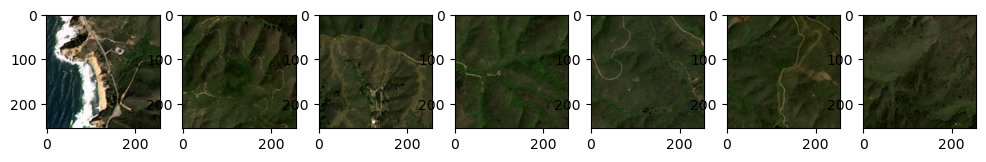

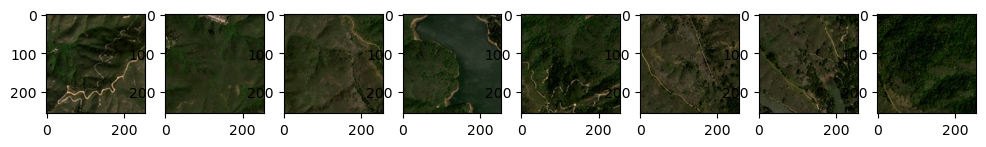

In [1049]:
# Some more analysis on trajectories and rewards. Get images from state 4,2:


filtered_df_for_displaying_in_report = df[df['state'].map(lambda x: x == [4,2])]
fig, ax = plt.subplots(1,filtered_df_for_displaying_in_report.shape[0], figsize=(12,12))
for n, i in enumerate(filtered_df_for_displaying_in_report['fp']):
    pil_img = Image.open(i)
    np_img = np.uint8(pil_img)
    ax[n].imshow(np_img)
    
filtered_df_for_displaying_in_report = df[df['state'].map(lambda x: x == [2,2])]
fig, ax = plt.subplots(1,filtered_df_for_displaying_in_report.shape[0], figsize=(12,12))

for n, i in enumerate(filtered_df_for_displaying_in_report['fp']):
    pil_img = Image.open(i)
    np_img = np.uint8(pil_img)
    ax[n].imshow(np_img)
    
    